## Heads up
*This data analysis exercice is inspired by a take-home task for candidates applying to be a Data Analyst in the Discovery department at Wikimedia Foundation. It was initially published in 2016 and is available here at https://github.com/wikimedia-research/Discovery-Hiring-Analyst-2016*

## Context
Discovery (and other teams within the Foundation) rely on event logging (EL) to track a variety of performance and usage metrics to help us make decisions. Specifically, Discovery is interested in:
- clickthrough rate: the proportion of search sessions where the user clicked on one of the results displayed
- zero results rate: the proportion of searches that yielded 0 results
and other metrics outside the scope of this task. EL uses JavaScript to asynchronously send messages (events) to our servers when the user has performed specific actions. In this task, you will analyze a subset of our event logs.

## Data

The dataset comes from a [tracking schema](https://meta.wikimedia.org/wiki/Schema:TestSearchSatisfaction2) that we use for assessing user satisfaction. Desktop users are randomly sampled to be anonymously tracked by this schema which uses a "I'm alive" pinging system that we can use to estimate how long our users stay on the pages they visit. The dataset contains just a little more than a week of EL data.

| Column          | Value   | Description                                                                       |
|:----------------|:--------|:----------------------------------------------------------------------------------|
| uuid            | string  | Universally unique identifier (UUID) for backend event handling.                  |
| timestamp       | integer | The date and time (UTC) of the event, formatted as YYYYMMDDhhmmss.                |
| session_id      | string  | A unique ID identifying individual sessions.                                      |
| group           | string  | A label ("a" or "b").                                     |
| action          | string  | Identifies in which the event was created. See below.                             |
| checkin         | integer | How many seconds the page has been open for.                                      |
| page_id         | string  | A unique identifier for correlating page visits and check-ins.                    |
| n_results       | integer | Number of hits returned to the user. Only shown for searchResultPage events.      |
| result_position | integer | The position of the visited page's link on the search engine results page (SERP). |

The following are possible values for an event's action field:

- **searchResultPage**: when a new search is performed and the user is shown a SERP.
- **visitPage**: when the user clicks a link in the results.
- **checkin**: when the user has remained on the page for a pre-specified amount of time.

### Example Session

|uuid                             |      timestamp|session_id       |group |action           | checkin|page_id          | n_results| result_position|
|:--------------------------------|:--------------|:----------------|:-----|:----------------|-------:|:----------------|---------:|---------------:|
|4f699f344515554a9371fe4ecb5b9ebc | 20160305195246|001e61b5477f5efc |b     |searchResultPage |      NA|1b341d0ab80eb77e |         7|              NA|
|759d1dc9966353c2a36846a61125f286 | 20160305195302|001e61b5477f5efc |b     |visitPage        |      NA|5a6a1f75124cbf03 |        NA|               1|
|77efd5a00a5053c4a713fbe5a48dbac4 | 20160305195312|001e61b5477f5efc |b     |checkin          |      10|5a6a1f75124cbf03 |        NA|               1|
|42420284ad895ec4bcb1f000b949dd5e | 20160305195322|001e61b5477f5efc |b     |checkin          |      20|5a6a1f75124cbf03 |        NA|               1|
|8ffd82c27a355a56882b5860993bd308 | 20160305195332|001e61b5477f5efc |b     |checkin          |      30|5a6a1f75124cbf03 |        NA|               1|
|2988d11968b25b29add3a851bec2fe02 | 20160305195342|001e61b5477f5efc |b     |checkin          |      40|5a6a1f75124cbf03 |        NA|               1|


This user's search query returned 7 results, they clicked on the first result, and stayed on the page between 40 and 50 seconds. (The next check-in would have happened at 50s.)

## Task
**You must create a reproducible report answering the following questions:**
1. What is our daily overall clickthrough rate? How does it vary between the groups?
2. Which results do people tend to try first? How does it change day-to-day?
3. What is our daily overall zero results rate? How does it vary between the groups?
4. Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship

## Exploring the data

In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 5]

data = pd.read_csv('../input/events-log/events_log.csv')

# Parse dates
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y%m%d%H%M%S')

# Print a sample
data.head(1000)

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
0,00000736167c507e8ec225bd9e71f9e5,2016-03-01 10:38:42,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN
1,00000c69fe345268935463abbfa5d5b3,2016-03-07 00:52:26,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN
2,00003bfdab715ee59077a3670331b787,2016-03-02 14:53:05,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN
3,0000465cd7c35ad2bdeafec953e08c1a,2016-03-02 22:27:01,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0
4,000050cbb4ef5b42b16c4d2cf69e6358,2016-03-02 09:50:23,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN
...,...,...,...,...,...,...,...,...,...
995,009d77ab43d75ad6beae7dc083eb5042,2016-03-02 05:06:38,08d43971e6c5910d,b,checkin,180.0,8780c2df637d5ba2,NaN,1.0
996,009d93982d705711a9a09f2bfd103057,2016-03-04 15:57:15,3e8476e8b1988c59,a,checkin,40.0,031075db11044cc6,NaN,1.0
997,009e1f6a2ede585e92e77699b4e46fbe,2016-03-04 14:36:39,792a2ee7f68946d3,a,checkin,180.0,9b2f238a960b7327,NaN,5.0
998,009e2b2ca7c95fd6bbaf254d52749221,2016-03-01 21:41:58,5d35c7ff1d31d048,a,checkin,90.0,c476ac26759837c2,NaN,1.0


## Task 1: overall daily clickthrough rate and how it varies by groups

As described earlier, the clickthrough rate is the proportion of search sessions where the user clicked on one of the results displayed. Some prelimnary questions need to be addressed in order to find out the clickthrough rate.

### How many search sessions per day?

Grouping the search sessions per day can be helpful to count and picture the daily number of sessions. 

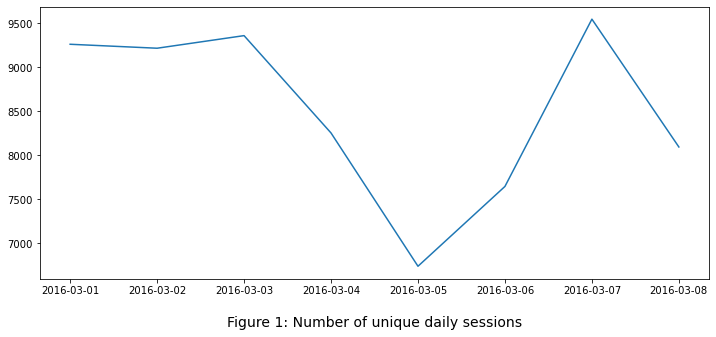

In [2]:
# get a collection of unique session_id
unique_sessions = data.groupby([data['timestamp'].dt.date])['session_id'].unique()

# build list of x and y labels
x_unique_sessions = [k for k, v in unique_sessions.items()]
y_unique_sessions = [len(v) for k, v in unique_sessions.items()]

# represent visually
plt.plot(x_unique_sessions, y_unique_sessions)
plt.xlabel('\nFigure 1: Number of unique daily sessions', fontsize=14)
plt.show()


### How many search sessions followed by a click?
A filtering operation can surface the sessions that led to clicks.

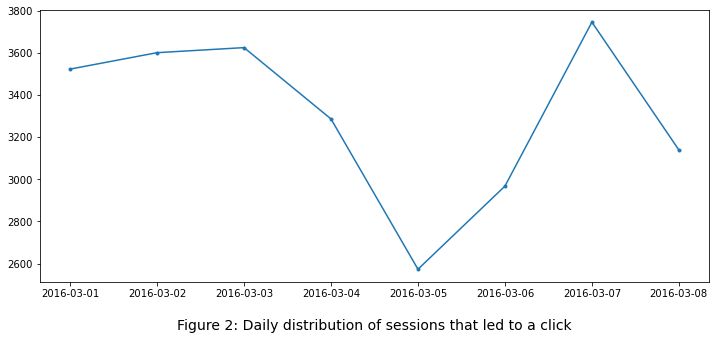

In [3]:
# get a collection of unique session_id linked to a click
unique_sessions_clicked = data[data['action']=='visitPage'].groupby([data['timestamp'].dt.date])['session_id'].unique()

# build list of x and y labels
x_unique_sessions_clicked = [k for k, v in unique_sessions_clicked.items()]
y_unique_sessions_clicked = [len(v) for k, v in unique_sessions_clicked.items()]

# represent visually
plt.plot(x_unique_sessions_clicked, y_unique_sessions_clicked, '.-')
plt.xlabel('\nFigure 2: Daily distribution of sessions that led to a click', fontsize=14)
plt.show()


### What percentage of search sessions yields clicks on a daily basis?

Based on the previous steps, computing the clickthrough is now possible. This number is the ratio between the daily number of sessions with clicks to the daily number 

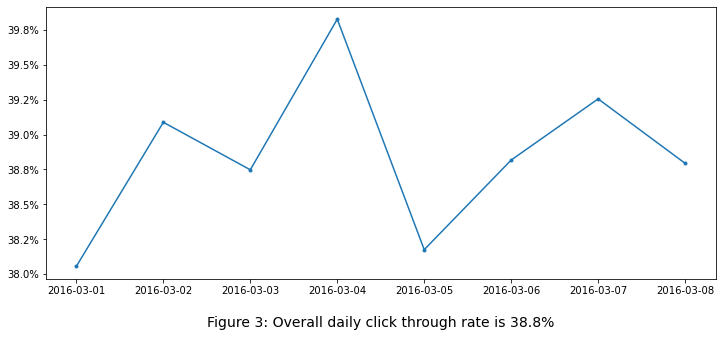

In [4]:
average_clickthrough_rate = 0

# build list of x and y labels
x_clickthrough_rate = [i for i in x_unique_sessions]
y_clickthrough_rate = [(y_unique_sessions_clicked[i]*100)/y_unique_sessions[i] for i in range(len(y_unique_sessions))]

# get the sum of all clickrates and average it
average_clickthrough_rate = sum(y_clickthrough_rate)/len(y_unique_sessions_clicked)

# represent visually
plt.plot(x_clickthrough_rate, y_clickthrough_rate, '.-')
plt.xlabel('\nFigure 3: Overall daily click through rate is {:.1f}%'.format(average_clickthrough_rate), fontsize=14)
plt.gca().set_yticklabels(['{:.1f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.show()
    


### Clickthrough rate distribution across groups?
Answering this question will require to examine each group's number of sessions where a user click and compare it against the total number of sessions.

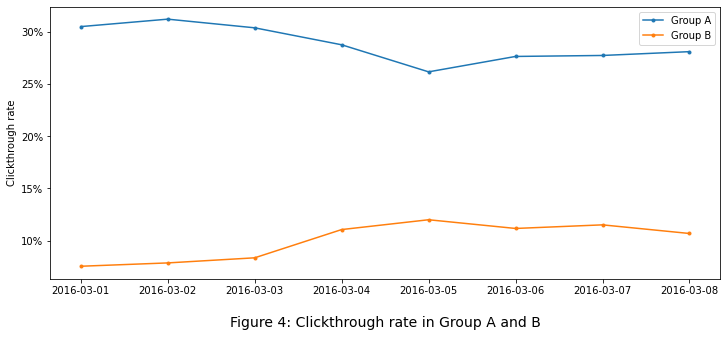

In [5]:
# get a collection of sessions for each group
unique_sessions_a = data[(data['action']=='visitPage') & (data['group']=='a')].groupby([data['timestamp'].dt.date])['session_id'].unique()
unique_sessions_b = data[(data['action']=='visitPage') & (data['group']=='b')].groupby([data['timestamp'].dt.date])['session_id'].unique()

# build list of x and y labels
x_clickthrough_rate_a = [k for k, v in unique_sessions_a.items()]
y_clickthrough_rate_a = [(len(unique_sessions_a[i])*100)/y_unique_sessions[i] for i in range(len(unique_sessions_a))]
y_clickthrough_rate_b = [(len(unique_sessions_b[i])*100)/y_unique_sessions[i] for i in range(len(unique_sessions_a))]

# represent visually
plt.xlabel('\nFigure 4: Clickthrough rate in Group A and B', fontsize=14)
plt.plot(x_clickthrough_rate_a, y_clickthrough_rate_a, '.-', label='Group A')
plt.plot(x_clickthrough_rate_a, y_clickthrough_rate_b, '.-', label='Group B')
plt.ylabel('Clickthrough rate')

# display percentage
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.show()


## Task 2: Which results do people tend to try first? How does it change day-to-day?
The most popular search position is 1, followed by, 2, and so on.
This does not vary across days. Instead, users appear to stick to that pattern.


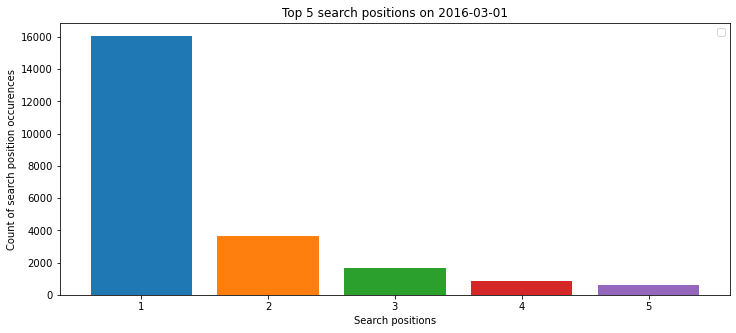

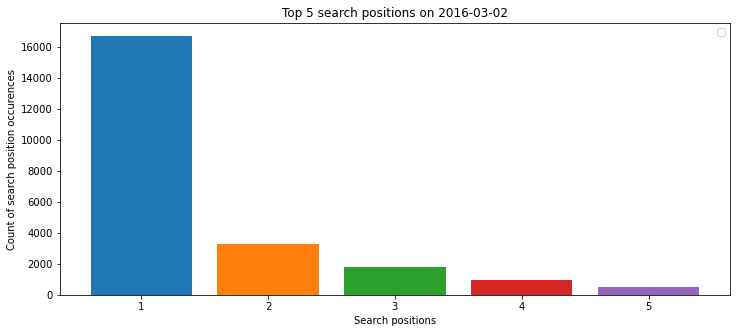

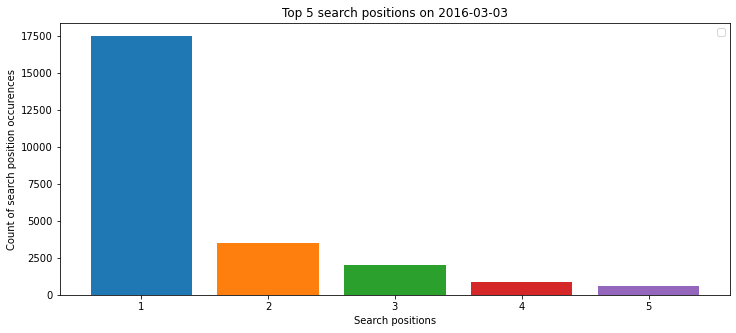

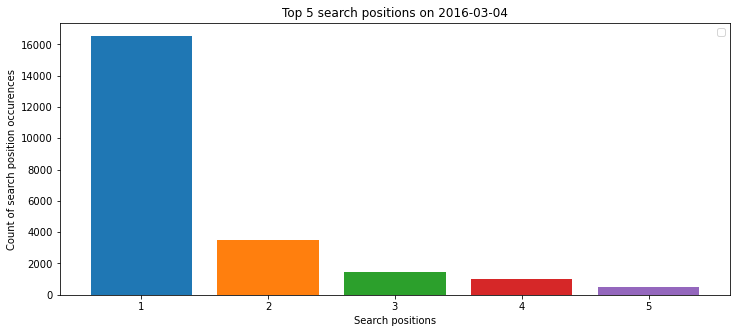

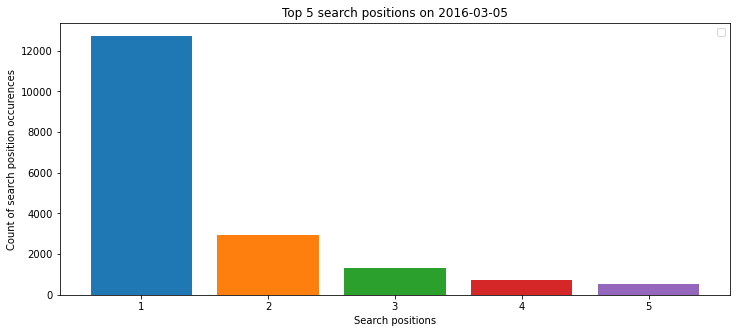

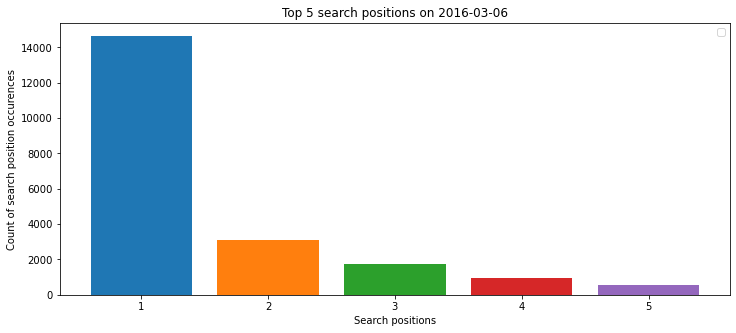

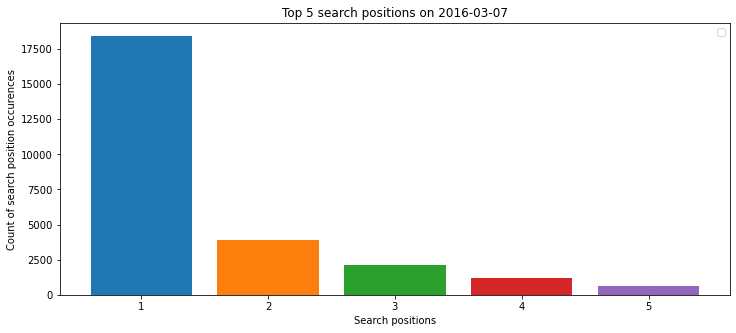

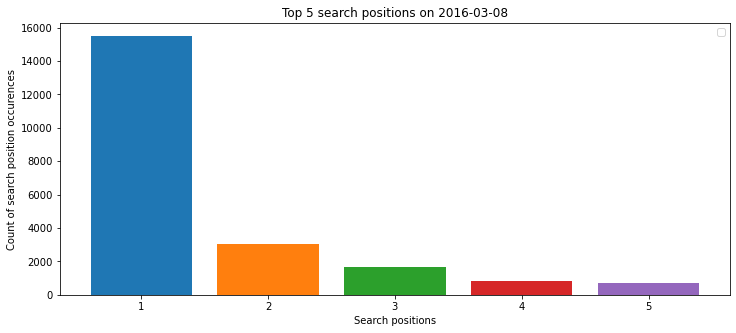

In [6]:
# filter out NaN results and group data by days in Y-m-d format
summary = data[(data['action'] == 'checkin') & (~data['result_position'].isnull())]
groups = summary.groupby(summary['timestamp'].dt.date)
days = [name.strftime('%Y-%m-%d') for name, group in groups]

# Get top 5 popular results
for day in days:
    group = summary[summary['timestamp'].dt.date == datetime.strptime(day, '%Y-%m-%d').date()]\
    .groupby(summary['timestamp'].dt.date)['result_position'].value_counts()[:5]
    plt.title('Top 5 search positions on {}'.format(day))
    
    # plot x, y dynamically
    for x, y in group.items():
        plt.bar(x[1], y)
    
    plt.xlabel('Search positions')
    plt.ylabel('Count of search position occurences')
    plt.legend()
    plt.show()

## Taks 3: Daily overall zero results rate? How does it vary between the groups?

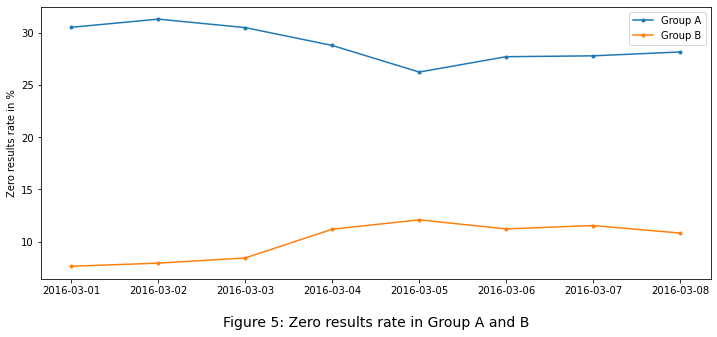

In [7]:
# get a collection of sessions for each group
unique_sessions_a = data[(data['n_results'].isnull()) & (data['group']=='a')].groupby([data['timestamp'].dt.date])['session_id'].unique()
unique_sessions_b = data[(data['n_results'].isnull()) & (data['group']=='b')].groupby([data['timestamp'].dt.date])['session_id'].unique()

# build list of x and y labels
x_zero_rate_a = [k for k, v in unique_sessions_a.items()]
y_zero_rate_a = [(len(unique_sessions_a[i])*100)/y_unique_sessions[i] for i in range(len(unique_sessions_a))]
y_zero_rate_b = [(len(unique_sessions_b[i])*100)/y_unique_sessions[i] for i in range(len(unique_sessions_a))]

# represent visually
plt.xlabel('\nFigure 5: Zero results rate in Group A and B', fontsize=14)
plt.plot(x_zero_rate_a, y_zero_rate_a, '.-', label='Group A')
plt.plot(x_zero_rate_a, y_zero_rate_b, '.-', label='Group B')
plt.ylabel('Zero results rate in %')
plt.legend()
plt.show()



The Zero results rate is higher in group A. However, this rate progresses differently from the rate in group B. For instance, while the zero results rate increased in Group B between March 03 and 05, Group B experienced a decrease of this rate during the same period.

## Task 4: Correlation between session length and user action
Let session length be approximately the time between the first event and the last event in a session. let's compare the relationship between the `session length` and the type of `action` that visitors tend to take.

### Sessions duration and frequency of actions 
The dataset contains mainly three types of actions: `checkin`, `searchResultPage`, and `visitPage`. Before visualizing the relationship between the duration of sessions and the type of action taken by users, the dataset needs to be rearranged, highlighting how many times each action was triggered during each session. The `duration` will come in handy later to infer conclusions.

In [8]:
# Get list of sessions
session_ids = data['session_id'].unique()
sessions_df = []

# Sort dataset by timestamp
data = data.sort_values(by='timestamp', ascending=True)

# build new dataset from a 500-long sample, indicate count of each 'action'
for session_id in session_ids[:500]:
    sample = data[data['session_id']== session_id].reset_index()
    group = sample.groupby('action')
    last = len(sample)-1
    for name, actions in group:
        duration = (sample['timestamp'][last] - sample['timestamp'][0]).seconds

        # duration in minutes
        sample['duration'] = duration / 60
        sample[name] = len(actions)
        
        sessions_df.append(sample.iloc[0])


summary = pd.DataFrame(sessions_df, columns = ['timestamp', 'session_id', 'group', 'duration', 'checkin', 'searchResultPage', 'visitPage'])
summary = summary.fillna(0)

# sort by duration
summary = summary.sort_values(by='duration', ascending=False).reset_index(drop=True)
summary.head(10)

,timestamp,session_id,group,duration,checkin,searchResultPage,visitPage
0,2016-03-03 00:07:47,8f563732ec2c918d,a,793.033333,71.0,0.0,0.0
1,2016-03-03 00:07:47,8f563732ec2c918d,a,793.033333,71.0,23.0,0.0
2,2016-03-03 00:07:47,8f563732ec2c918d,a,793.033333,71.0,23.0,16.0
3,2016-03-03 14:13:56,b1b9ad0b289027e1,a,57.966667,131.0,0.0,0.0
4,2016-03-03 14:13:56,b1b9ad0b289027e1,a,57.966667,131.0,45.0,0.0
5,2016-03-03 14:13:56,b1b9ad0b289027e1,a,57.966667,131.0,45.0,47.0
6,2016-03-01 05:33:13,0d7ea610d7227cc3,a,50.883333,53.0,0.0,0.0
7,2016-03-01 05:33:13,0d7ea610d7227cc3,a,50.883333,53.0,27.0,0.0
8,2016-03-01 05:33:13,0d7ea610d7227cc3,a,50.883333,53.0,27.0,8.0
9,2016-03-04 21:14:24,d4ae2c4edeb9b2c9,a,44.366667,0.0,37.0,0.0


The table hints at a corelation between session `duration` and `action`, especially the `checkin`. Let's represent that relation visually.

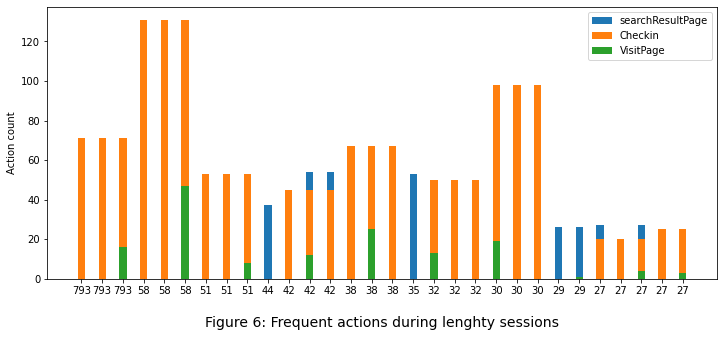

In [9]:
summary = summary
labels = ['{:.0f}'.format(x) for x in summary['duration'][:30]]

# indicate label locations
x = np.arange(len(labels))  

# set width of the bars
width = 0.35  

# plot only top 10 results
fig, ax = plt.subplots()
ax.bar(x, summary['searchResultPage'][:30], width, label='searchResultPage')
ax.bar(x, summary['checkin'][:30], width, label='Checkin')
ax.bar(x, summary['visitPage'][:30], width, label='VisitPage')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Action count')
ax.set_xlabel('Duration of sessions in minutes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xlabel('\nFigure 6: Frequent actions during lenghty sessions', fontsize=14)

# represent visually
plt.show()

### Observations
- **Search queries are scarce when duration is high**. Generally, the lengthiest sessions are those where users do not perform any search queries.
- **Very few links are clicked during lenthy sessions**. While some lenghty sessions include `visitPage` actions, it is worth noting that they are generally minimal. This suggests that visitors who spend a long time on the platform tend to come for a single page and remain on it most of the time.  